# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

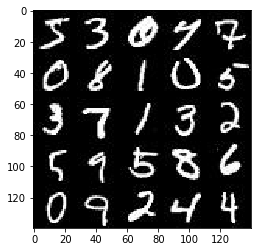

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

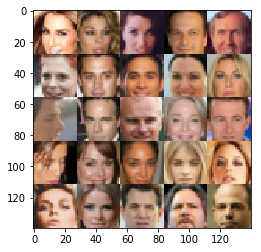

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\anwar\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_i = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='real_input')
    z_i = tf.placeholder(tf.float32,(None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='lr')
    return (r_i, z_i, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    hidden = 128
    alpha = 0.01
    # input images are 28x28x3
    print("image shape:::", images.get_shape())
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.nn.dropout(relu1,0.75)
        print("relu1 shape:::", relu1.get_shape())
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,0.7)
        print("relu2 shape:::", relu2.get_shape())
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,0.7)
        print("relu3 shape:::", relu3.get_shape())
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        print("relu4 shape:::", relu4.get_shape())
        relu4 = tf.nn.dropout(relu4,0.7)
        # 2x2x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

image shape::: (?, 28, 28, 3)
relu1 shape::: (?, 14, 14, 64)
relu2 shape::: (?, 7, 7, 128)
relu3 shape::: (?, 4, 4, 256)
relu4 shape::: (?, 2, 2, 512)
image shape::: (?, 28, 28, 3)
relu1 shape::: (?, 14, 14, 64)
relu2 shape::: (?, 7, 7, 128)
relu3 shape::: (?, 4, 4, 256)
relu4 shape::: (?, 2, 2, 512)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        #x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        print("x1 shape:::", x1.get_shape())
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        print("x2 shape:::", x2.get_shape())
        # 4x4x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        print("x3 shape:::", x3.get_shape())
        x3 = tf.nn.dropout(x3, 0.7)
        # 7x7x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        print("x4 shape:::", x4.get_shape())
        x4 = tf.nn.dropout(x4, 0.7)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        print("logits shape:::", logits.get_shape())
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

x1 shape::: (?, 2, 2, 512)
x2 shape::: (?, 4, 4, 256)
x3 shape::: (?, 7, 7, 128)
x4 shape::: (?, 14, 14, 64)
logits shape::: (?, 28, 28, 5)
x1 shape::: (?, 2, 2, 512)
x2 shape::: (?, 4, 4, 256)
x3 shape::: (?, 7, 7, 128)
x4 shape::: (?, 14, 14, 64)
logits shape::: (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

x1 shape::: (?, 2, 2, 512)
x2 shape::: (?, 4, 4, 256)
x3 shape::: (?, 7, 7, 128)
x4 shape::: (?, 14, 14, 64)
logits shape::: (?, 28, 28, 4)
image shape::: (?, 28, 28, 4)
relu1 shape::: (?, 14, 14, 64)
relu2 shape::: (?, 7, 7, 128)
relu3 shape::: (?, 4, 4, 256)
relu4 shape::: (?, 2, 2, 512)
image shape::: (?, 28, 28, 4)
relu1 shape::: (?, 14, 14, 64)
relu2 shape::: (?, 7, 7, 128)
relu3 shape::: (?, 4, 4, 256)
relu4 shape::: (?, 2, 2, 512)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 50
    print("data_shape::", data_shape[0],data_shape[1],data_shape[2],data_shape[3])
    #tf.reset_default_graph()
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                steps += 1
                # TODO: Train Model
                # Sample random noise for Generators
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
 
        #saver.save(sess, './checkpoints/generator.ckpt')
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape:: 60000 28 28 1
x1 shape::: (?, 2, 2, 512)
x2 shape::: (?, 4, 4, 256)
x3 shape::: (?, 7, 7, 128)
x4 shape::: (?, 14, 14, 64)
logits shape::: (?, 28, 28, 1)
image shape::: (?, 28, 28, 1)
relu1 shape::: (?, 14, 14, 64)
relu2 shape::: (?, 7, 7, 128)
relu3 shape::: (?, 4, 4, 256)
relu4 shape::: (?, 2, 2, 512)
image shape::: (?, 28, 28, 1)
relu1 shape::: (?, 14, 14, 64)
relu2 shape::: (?, 7, 7, 128)
relu3 shape::: (?, 4, 4, 256)
relu4 shape::: (?, 2, 2, 512)
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 5.5119
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 4.0787
Epoch 1/1... Discriminator Loss: 0.0765... Generator Loss: 4.7706
x1 shape::: (?, 2, 2, 512)
x2 shape::: (?, 4, 4, 256)
x3 shape::: (?, 7, 7, 128)
x4 shape::: (?, 14, 14, 64)
logits shape::: (?, 28, 28, 1)


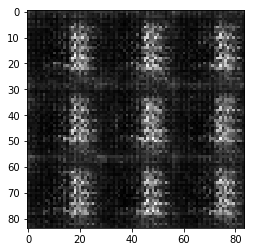

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 4.9899
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 3.1048
Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 3.3305
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 4.5108
x1 shape::: (?, 2, 2, 512)
x2 shape::: (?, 4, 4, 256)
x3 shape::: (?, 7, 7, 128)
x4 shape::: (?, 14, 14, 64)
logits shape::: (?, 28, 28, 1)


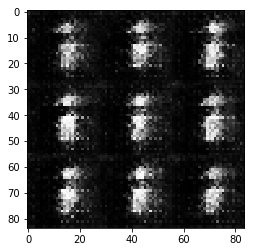

Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 2.5068
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 3.9704
Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 7.5728
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 2.7410
x1 shape::: (?, 2, 2, 512)
x2 shape::: (?, 4, 4, 256)
x3 shape::: (?, 7, 7, 128)
x4 shape::: (?, 14, 14, 64)
logits shape::: (?, 28, 28, 1)


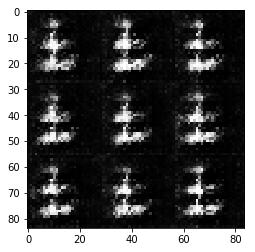

Epoch 1/1... Discriminator Loss: 0.3066... Generator Loss: 3.2413
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 6.7257
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 0.2981... Generator Loss: 3.0155


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape:: 202599 28 28 3
image shape::: (?, 28, 28, 3)
image shape::: (?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.3114... Generator Loss: 1.9051
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 2.4473
Epoch 1/1... Discriminator Loss: 0.1558... Generator Loss: 2.7277
Epoch 1/1... Discriminator Loss: 0.2163... Generator Loss: 2.0584
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 2.4496
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 2.4407
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 3.2525
Epoch 1/1... Discriminator Loss: 0.3215... Generator Loss: 1.8535
Epoch 1/1... Discriminator Loss: 0.2751... Generator Loss: 2.5250


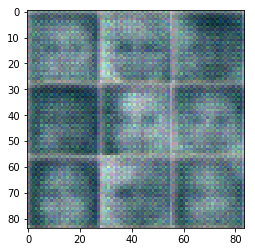

Epoch 1/1... Discriminator Loss: 2.6443... Generator Loss: 10.1755
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 2.0205
Epoch 1/1... Discriminator Loss: 0.2996... Generator Loss: 3.8882
Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 2.8177
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 1.8549
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 3.1773
Epoch 1/1... Discriminator Loss: 0.1946... Generator Loss: 2.1934
Epoch 1/1... Discriminator Loss: 1.9339... Generator Loss: 0.2100
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 4.6811
Epoch 1/1... Discriminator Loss: 0.0965... Generator Loss: 3.7073


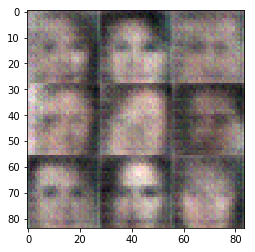

Epoch 1/1... Discriminator Loss: 1.7535... Generator Loss: 6.3046
Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 2.0664
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 2.2638
Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 3.8143
Epoch 1/1... Discriminator Loss: 0.0620... Generator Loss: 4.1302
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.3338
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 4.4059
Epoch 1/1... Discriminator Loss: 1.8086... Generator Loss: 7.6966
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 1.4695


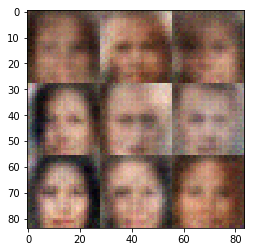

Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 3.5078
Epoch 1/1... Discriminator Loss: 0.2072... Generator Loss: 4.9854
Epoch 1/1... Discriminator Loss: 4.5454... Generator Loss: 7.4036
Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 2.9999
Epoch 1/1... Discriminator Loss: 0.0728... Generator Loss: 3.7230
Epoch 1/1... Discriminator Loss: 0.0459... Generator Loss: 3.8724
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 3.6209
Epoch 1/1... Discriminator Loss: 1.8740... Generator Loss: 0.2202
Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 2.4063
Epoch 1/1... Discriminator Loss: 2.6864... Generator Loss: 0.1008


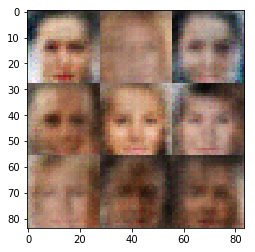

Epoch 1/1... Discriminator Loss: 0.1790... Generator Loss: 2.5393
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 3.4611
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 8.5960
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 5.4869
Epoch 1/1... Discriminator Loss: 0.2016... Generator Loss: 2.1203
Epoch 1/1... Discriminator Loss: 0.1725... Generator Loss: 8.3204
Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 2.2927
Epoch 1/1... Discriminator Loss: 0.1690... Generator Loss: 4.5803
Epoch 1/1... Discriminator Loss: 0.0901... Generator Loss: 3.1375


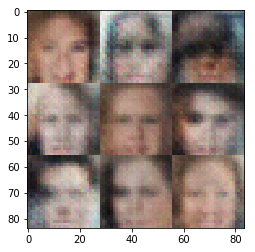

Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 4.1101
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 5.0943
Epoch 1/1... Discriminator Loss: 0.0886... Generator Loss: 2.8758
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.3025
Epoch 1/1... Discriminator Loss: 0.1125... Generator Loss: 4.3018
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 6.4063
Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 4.4364
Epoch 1/1... Discriminator Loss: 0.0501... Generator Loss: 4.9706
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 9.5233


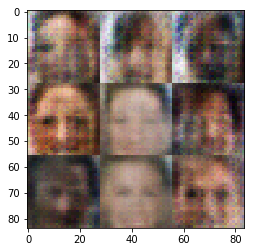

Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.7459
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 11.9036
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 4.3059
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 1.4586
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 3.9299
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 9.7644
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 8.9963


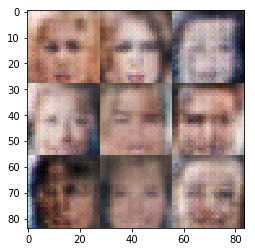

Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 8.7281
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 13.1037
Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 12.0494
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 6.8741
Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 3.9837
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.9362
Epoch 1/1... Discriminator Loss: 0.0845... Generator Loss: 2.9923
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.3363
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 5.9256


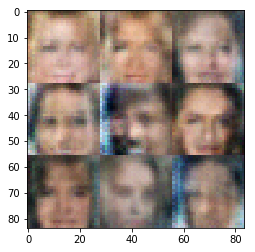

Epoch 1/1... Discriminator Loss: 0.0593... Generator Loss: 9.7977
Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 9.3312
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 7.5241
Epoch 1/1... Discriminator Loss: 0.0079... Generator Loss: 7.0480
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 11.1531
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 6.2554
Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 7.3668
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 7.6209
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 12.5436


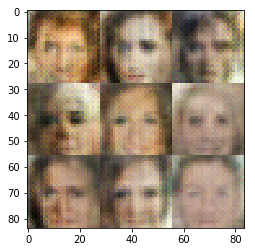

Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 9.5286
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 15.8218
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 10.7759
Epoch 1/1... Discriminator Loss: 0.0329... Generator Loss: 8.5094
Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 4.0996
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 2.8122
Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 9.5464
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 6.4563
Epoch 1/1... Discriminator Loss: 0.0838... Generator Loss: 5.2205
Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 13.2235


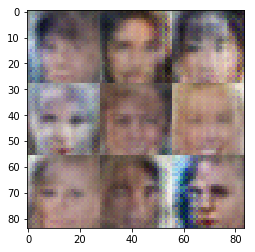

Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 6.2897
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 10.3545
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 6.2065
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 5.2750
Epoch 1/1... Discriminator Loss: 3.3207... Generator Loss: 8.7604
Epoch 1/1... Discriminator Loss: 0.5033... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 12.4165
Epoch 1/1... Discriminator Loss: 0.0498... Generator Loss: 7.6486
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 7.1604


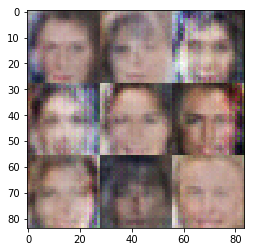

Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 7.6508
Epoch 1/1... Discriminator Loss: 0.0222... Generator Loss: 4.9971
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 8.1596
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 12.1471
Epoch 1/1... Discriminator Loss: 0.1488... Generator Loss: 10.6521
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 11.4800
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 15.0400
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 6.2824
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 9.4095
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 15.7910


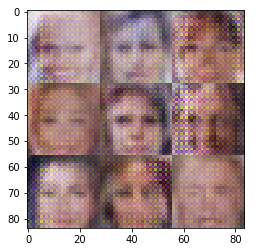

Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 10.4894
Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 5.0903
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 3.1005
Epoch 1/1... Discriminator Loss: 0.0751... Generator Loss: 9.4166
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 10.4180
Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 9.3477
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 13.4344
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 5.8118
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 10.7533
Epoch 1/1... Discriminator Loss: 0.1244... Generator Loss: 13.1495


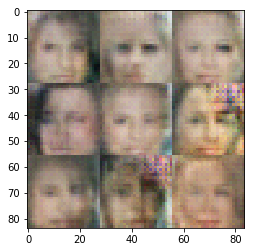

Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 14.3960
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 7.1783
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 8.7224
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 14.3520
Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 6.9084
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 11.4548
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 10.1219
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 4.1697
Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 7.5734
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 8.8527


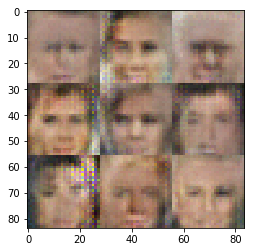

Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 8.3317
Epoch 1/1... Discriminator Loss: 0.0233... Generator Loss: 6.6384
Epoch 1/1... Discriminator Loss: 0.1280... Generator Loss: 5.8120
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 7.3520
Epoch 1/1... Discriminator Loss: 0.1546... Generator Loss: 3.1817
Epoch 1/1... Discriminator Loss: 0.1348... Generator Loss: 8.3995
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 8.0126
Epoch 1/1... Discriminator Loss: 0.3000... Generator Loss: 3.5832
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 11.8926


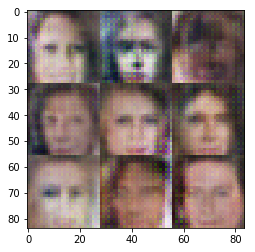

Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 3.7995
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 8.2418
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 7.6052
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 10.7898
Epoch 1/1... Discriminator Loss: 0.1518... Generator Loss: 4.2436
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 0.0055... Generator Loss: 11.3312


In [17]:
batch_size = 128
z_dim = 72
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.